# K-NN Tree 

### Single trace classifier, clustering, regressor

Baseline thinking:

* Tree grows with distance confidence
* Starts with just two points and/or one distance
* Evaluates new data point with smallest possible data and higher confidence
* trying to find internal regoins of confidence within data points or cluster
* Points selected to score are basically edges points of regions of confidence.
* Image to be attached of baseline method

Cons as of now:

* Two points are a mandate.. Cant start with no points. Atleast one point and one distance is a requirement.

Considerations:

* Worst case distance calculation O(kn) where k is neghbours and n is no of reference points in tree
* Space complexity of training data reduces to O(kn+m) compared to data in whole, where m is number of nodes in the tree
* online learning
* parallel / distributed learning possible


In [1]:
import numpy as np
from scipy.spatial import distance, distance_matrix 
import pandas as pd

In [2]:
from sklearn.datasets import load_boston, load_breast_cancer, load_iris

In [3]:
def get_data(dataname):
    
    if dataname == 'iris':
        data = load_iris()
    elif dataname == 'boston':
        data = load_boston()
    elif dataname == 'cancer':
        data = load_breast_cancer()
    df  = pd.concat([pd.DataFrame(data.data),pd.DataFrame(data.target)],axis = 1)
    names = [i for i in data.feature_names]
    names.append('target')
    df.columns = names
    print(df.head())
    print(df.describe())
    return df

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
class TreeNode(object):
    
    def __init__(self, parent, k, depth, confidence, d_measure):
        self.parent= parent
        self.children = []
        self.points = np.array([])
        self.k = k
        self.depth = depth
        self.visit = 1
        self.distance = None
        self._k = self.points.shape[0]
        self.confidence = confidence
        self.d_measure = d_measure
        self.d_measure_args = []
        self.is_leaf = False
        
        # k_array stores Index, distance, cluster and visits to other centroids
        # this is for self evaluation
        self.k_array = np.zeros((4,self.k+1))
        self.history = np.array([])
        self.data = np.array([])

    def update(self, leaf_value):
        """Update node values from leaf evaluation.
        leaf_value: the value of subtree evaluation from the current data
            perspective.
        """
        # Count visit.
        self.n_visits += 1
        # Update Q, a running average of values for all visits.
        self.Q += 1.0*(leaf_value - self.Q) / self.n_visits

    def update_recursive(self, leaf_value):
        """Like a call to update(), but applied recursively for all ancestors.
        """
        # If it is not root, this node's parent should be updated first.
        if self.parent:
            self.parent.update_recursive(-leaf_value)
        self.update(leaf_value)
    
    def get_centroid(self,data):
        # """Calculate and return the value for this node.
        # It is a combination of leaf evaluations Q, and this node's prior
        # adjusted for its visit count, u.
        # c_puct: a number in (0, inf) controlling the relative impact of
        #     value Q, and prior probability P, on this node's score.
        # """
        # self.u = (c_puct * self.P *
        #            np.sqrt(self.parent.n_visits) / (1 + self.n_visits))
        # return self.Q + self.u
        return np.nanmean(data[self.k_array[:,0],:],axis = 0)

    def collect_data(self,data):
        return data[self.k_array[:,0],:]
    
    def score_data(self, data, point):
        return distance.cdist(data, point, metric=self.d_measure, *self.d_measure_args)
    
    def interdistances(self):
        return distance.cdist(self.points, self.points, metric=self.d_measure, *self.d_measure_args)

    def expand(self,points):
        
        if self.points.shape[0] == 0:
            self.points = [0,1]
            
        clusters = []
        if len(self.clusters) == 0:
            dist = self.score_data(self.data, points)
            d_conf = (np.max(dist) - np.min(dist)) * self.confidence
            print(dist)
            print(d_conf)
            for pts in self.points:
                child_clust = TreeNode(self, k=self.k ,depth=self.depth+1, confidence = self.confidence, d_measure = self.d_measure)
                child_clust.points = pts
                child_clust.distance = d_conf
                child_clust._k = 1
                child_clust.history = pts
                clusters.append(child_clust)
            self.clusters = clusters
            self.distance = d_conf
        else:
            for child_clust in self.clusters:
                child_clust.expand(points)

    
        for clust in self.clusters:
            print(clust.points)
            print(clust)
            
        
    def is_leaf(self):
        """Check if leaf node (i.e. no nodes below this have been expanded).
        """
        return self.children == []

    def has_data(self):
        return self.points is None
    
    def __repr__(self):
        
        s = 'Cluster has Points: {} Know Neighbours: {} D_conf: {:3.4f} Depth: {:2d} Visits :{:2d} History: {} '.format(self.points.shape,
                            np.sum(self.k_array !=0 ), self.confidence, self.depth , self.value, self.history.shape)
        
        return s
        
    
class KNNTree(object):
    
    def __init__(self, k=5, d_conf=0.3, clusters = None, min_centroid_pts = 2, max_centroid_pts = 100, prune_at=5, history_stack=10000, measure='euclidean',):
        self.k  = k 
        self.d_conf = 0.3
        self.clusters = clusters
        self.min_centroid_pts = min_centroid_pts
        self.max_centroid_pts = max_centroid_pts
        self.prune_at = prune_at
        self.history_stack = history_stack
        self.measure = measure
        
        self.tree = TreeNode(None, depth=1, k = self.k, confidence= self.d_conf, d_measure=self.measure)
        self.data = None
        self.maxdepth = None
        
        
    def fit(self, newdata):
        if self.tree.has_data() and newdata.shape[0] <2:
            raise ValueError('Tree cannot be initiated with less than two points')
        if self.data is None:
            self.data = newdata
        else:
            self.data = np.concatenate((self.data,newdata),axis = 0)
        
        dist = self.tree.expand(newdata)
        
        
    

In [7]:
class TreeNode(object):
    
    def __init__(self, parent, k, depth, confidence, d_measure):
        self.parent= parent
        self.name = None
        self.children = []
        self.k = k
        self.depth = depth
        self.visit = 1
        self.distance = None
        self._k = None
        self.confidence = confidence
        self.d_measure = d_measure
        self.d_measure_args = []
        self.is_leaf = False
        self.index = None
        self.centroid = 0 # zero means false and 1 means true
        
        # k_array stores 0:Index, 1:distance, 2:is index centriod and 3:visits to other centroids
        # this is for self evaluation
        self.k_array = np.zeros((4,self.k))
        self.history = np.array([])
        self.data = np.array([])
        
    def score_data(self, data, point):
        return distance.cdist(data, point, metric=self.d_measure, *self.d_measure_args)
    
    def _know_my_interdistances(self, data, indexes):
        return distance.cdist(data[indexes,:], data[indexes,:], metric=self.d_measure, *self.d_measure_args)
    
    def _get_centroid(self,data):
        idx = np.unique(self.k_array[0,:].astype(np.int64))
        min_idx = np.min(idx)
        idx = np.delete(idx, idx.argmin())
        return np.nanmean(data[idx,:],axis = 0), min_idx, idx
    
    def expand(self, data, dist, index):
        
        if len(self.children) == 0:
            d_conf = np.max(dist) * self.confidence
            child = TreeNode(self, k=self.k ,depth=self.depth+1, confidence = self.confidence, d_measure = self.d_measure)
            child_ = TreeNode(self, k=self.k ,depth=self.depth+1, confidence = self.confidence, d_measure = self.d_measure)
            
            # giving name to child
            child.name = 1
            child_.name = 2
            
            #giving confidence region to look for
            child.distance = d_conf
            child_.distance = d_conf
            
            #updating self position
            child.index = index[0]
            child_.index = index[1]
    
            self.children = [child,child_]
            return data, False
        else:
            test_child = []
            child_distance = []
            child_info =[]
            for child in self.children:
                s, d = child._are_you_my_neighbour(dist,index)
                test_child.append(s)
                child_distance.append(d)
                child_info.append(child._recall_self())
            
            if np.sum(test_child) == 0:
                # time to add new child
                child = TreeNode(self, k=self.k ,depth=self.depth+1, confidence = self.confidence, d_measure = self.d_measure)
                child.name = np.max([i[0] for i in child_info]) + 1
                child.index = index
                
                self.children.append(child)
                child_info.append(child._recall_self())
                
                # update confidence distance for all children
                d_conf = (np.max(dist) - np.min(dist[np.where(dist != 0)])) * self.confidence                
                for child in self.children:
                    child.distance = d_conf
                return data, False
            else:
                d_conf = (np.max(dist) - np.min(dist)) * self.confidence 
                for i,test in enumerate(test_child):
                    if test:
                        child = self.children[i]
                        status, data = child._update_self_recursive(data, d_conf, dist, index)
                        if status:
                            # if status is there rebuild tree else its just an update
                            return data, True
                        self.children[i] = child
                return data, False
                
    def _recall_self(self):
        return self.name, self.index, self.depth, self.distance
    
    def _are_you_my_neighbour(self, dist, index):
        
        d = dist[self.index] if self.index is not None else np.min(dist)
        
        # print('d:{} dist:{}'.format(d,self.distance))
        if d <= self.distance:
            return True, d
        else:
            if len(self.children) == 0:
                return False, d
            else:
                status = []
                distance = []
                for child in self.children:
                    s,d=child._are_you_my_neighbour(dist,index)
                    status.append(s)
                    distance.append(d)
                if np.any(s):
                    return True, np.min(distance[status])
                else: 
                    return False, np.min(distance)
    
    def _update_self_recursive(self, data, d_conf, dist, index):
        if len(self.children) == 0:
            # return everything how good or bad update is
            return self._update_self(data, d_conf, dist, index)
        else:
            # notify all children that new data is there and have to recaliberate
            for child in self.children:
                status, data = self._update_self(data, d_conf, dist, index)
                if status:
                    return status, data
            # else return everything is normal
            return False,data
                
            
                
    def _update_self(self, data, d_conf, dist, index):
        
        self.visit += 1
        is_neighbour = np.where(self.k_array[3,:] == 0 )
        is_centroid = np.where(self.k_array[2,:] != 0 )
        if np.sum(is_neighbour) == 0:

            if np.sum(is_centroid) == 0: # or criteria for centroid points is to be used
                centroid, idx, del_idx = self._get_centroid(data)
#                 print(centroid, idx, del_idx)
                np.delete(data,del_idx)
#                 print(data[idx,:])
                data[idx,:] = np.array([centroid])
                self.index = idx
                self.centroid = 1
                return True, data
            else:
                child_ = TreeNode(self, k=self.k ,depth=self.depth+1, confidence = self.confidence, d_measure = self.d_measure)
                child_.name = self.name
                # getting index with smallest distances from centroid point
                indexes = np.unique(self.k_array[0,is_centroid]).astype(np.int64)
#                 print(indexes)
                c_dist = dist[indexes]
                child_.index = self.k_array[0,np.argmin(c_dist)].astype(np.int64)
                child_.distance = np.max(self._know_my_interdistances(data,indexes)) * self.confidence
                print('New child created with :\n{}'.format(child_.__repr__(oneliner=True)))
                self.children=[child_]  
                return False, data
        else:
            self.distance = d_conf
            idx = np.min(is_neighbour)
            print(self._recall_self())
            d = dist[self.index]
            self.k_array[0,idx] = index
            self.k_array[1,idx] = d
            self.k_array[2,idx] = self.centroid
            self.k_array[3,idx] = self.name
            print('name:{} index: {} update k_array:\n{}'.format(self.name, self.index, self.k_array))
            return False, data
       
                
    def __repr__(self, oneliner = False):
        
        self_s = 'Node Depth :{} Name: {} Index :{} Is Centroid: {} Childrens :{}\n'.format(
            (self.depth + 1), self.name ,self.index, 'Yes' if self.centroid == 1 else 'No', len(self.children))
        
        if oneliner:
            return self_s
        
        if self.depth == 0:
            spacer = '|~~'
        else:
            spacer = '|  '*(self.depth)+'|~~'

        s = spacer + self_s

        if len(self.children) != 0:
            for i in self.children:
                s += i.__repr__()
        return s
    
    def no_tree(self):
        return len(self.children) == 0

In [8]:
class KNNTree(object):
    
    def __init__(self, k=5, d_conf=0.3, clusters = None, points_to_centroid = 2, caliberate_tree_at = 100, prune_at=5, history_stack=10000, measure='euclidean',):
        self.k = k 
        self.d_conf = 0.3
        self.clusters = clusters
        self.points_to_centroid = points_to_centroid
        self.caliberate_tree_at = caliberate_tree_at
        self.prune_at = prune_at
        self.history_stack = history_stack
        self.measure = measure
        
        self.tree = TreeNode(None, depth=0, k = self.k, confidence= self.d_conf, d_measure=self.measure)
        self.data = None
        self.history = None
        self.maxdepth = None
        self.c_counter = 0
        
        
    def fit(self, newdata):
        if self.tree.no_tree() and newdata.shape[0] <2:
            raise ValueError('Tree cannot be initiated with less than two points')
        if self.data is None:
            self.data = newdata
            self.history = newdata
        else:
            self.history = np.concatenate((self.history,newdata),axis = 0)
            self.data = np.concatenate((self.data,newdata),axis = 0)
    
        self.c_counter += 1
        dist = self.tree.score_data(self.data[:-1,:],newdata)
        self.tree.distance = np.max(dist)
        d_shape = self.data.shape[0]
        self.data, status = self.tree.expand(self.data, dist, [0,1] if d_shape == 2 else d_shape-1)
        if status:
            print('\nCentroid found! Recaliberating Tree!\n')
            newdata_ = self.data[:2,:]
            self.tree = TreeNode(None, depth=0, k = self.k, confidence= self.d_conf, d_measure=self.measure)
            dist = self.tree.score_data(newdata_,newdata_)
            self.tree.distance = np.max(dist)
            d_shape = newdata_.shape[0]
            data, _ = self.tree.expand(newdata_, dist, [0,1] if d_shape == 2 else d_shape-1)
            for pts in self.data[2:,:]:
     
                data = np.concatenate((data,np.array([pts])),axis = 0)
                dist = self.tree.score_data(data[:-1,:],newdata)
                self.tree.distance = np.max(dist)
                d_shape = data.shape[0]
                data, status = self.tree.expand(data, dist, [0,1] if d_shape == 2 else d_shape-1)
            
        # rules for centroid partly done and caliberation yet to be done
   
    def get_centriod_distances(self):
        return self.tree._know_my_interdistances(self.data,np.arange(self.data.shape[0]))
    
    def score(self, newdata):
        dist = self.tree.score_data(self.data,newdata)
        print(dist)
        return self.tree._are_you_my_neighbour(dist, self.data.shape[0])
    
    def __repr__(self):
        s = self.tree.__repr__()
        return s

In [9]:
knntree = KNNTree(k=2,measure='cityblock')

In [10]:
knntree.fit(np.array([[0,0],[0,10]]))

In [11]:
knntree

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :2
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0

In [12]:
knntree.fit(np.array([[3,4]]))

In [13]:
knntree
knntree.data

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :3
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 3 Index :2 Is Centroid: No Childrens :0

array([[ 0,  0],
       [ 0, 10],
       [ 3,  4]])

In [14]:
knntree.score(np.array([[1,2]]))
knntree.score(np.array([[10,2]]))
knntree.score(np.array([[50,4]]))

[[3.]
 [9.]
 [4.]]


(True, 3.0)

[[12.]
 [18.]
 [ 9.]]


(True, 9.0)

[[54.]
 [56.]
 [47.]]


(False, 47.0)

In [15]:
knntree.fit(np.array([[1,2]]))
knntree.fit(np.array([[10,2]]))
knntree.fit(np.array([[5,2]]))
knntree.fit(np.array([[7,1]]))
knntree.fit(np.array([[3,3]]))
knntree.fit(np.array([[4,5]]))
knntree.fit(np.array([[2,2]]))
knntree.fit(np.array([[0,1]]))
knntree.fit(np.array([[0,3]]))
knntree.fit(np.array([[0,9]]))
knntree.fit(np.array([[0,11]]))
knntree.fit(np.array([[6,5]]))
knntree.fit(np.array([[4,2]]))
knntree.fit(np.array([[14,2]]))
knntree.fit(np.array([[2,2]]))
knntree.fit(np.array([[2,1]]))
knntree
knntree.fit(np.array([[3,3]]))
knntree.fit(np.array([[4,5]]))

(3, 2, 1, 2.6999999999999997)
name:3 index: 2 update k_array:
[[7. 0.]
 [1. 0.]
 [0. 0.]
 [3. 0.]]
(4, 3, 1, 2.6999999999999997)
name:4 index: 3 update k_array:
[[7. 0.]
 [3. 0.]
 [0. 0.]
 [4. 0.]]
(6, 5, 1, 2.6999999999999997)
name:6 index: 5 update k_array:
[[7. 0.]
 [3. 0.]
 [0. 0.]
 [6. 0.]]
(3, 2, 1, 2.1)
name:3 index: 2 update k_array:
[[7. 8.]
 [1. 2.]
 [0. 0.]
 [3. 3.]]
(4, 3, 1, 2.6999999999999997)
name:4 index: 3 update k_array:
[[7. 9.]
 [3. 1.]
 [0. 0.]
 [4. 4.]]
(1, 0, 1, 3.0)
name:1 index: 0 update k_array:
[[10.  0.]
 [ 1.  0.]
 [ 0.  0.]
 [ 1.  0.]]

Centroid found! Recaliberating Tree!

(1, 0, 1, 2.4)
name:1 index: 0 update k_array:
[[2. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]]
(1, 0, 1, 2.4)
name:1 index: 0 update k_array:
[[2. 3.]
 [1. 1.]
 [0. 0.]
 [1. 1.]]
(2, 1, 1, 4.8)
name:2 index: 1 update k_array:
[[12.  0.]
 [ 1.  0.]
 [ 0.  0.]
 [ 2.  0.]]
(2, 1, 1, 5.3999999999999995)
name:2 index: 1 update k_array:
[[12. 13.]
 [ 1.  1.]
 [ 0.  0.]
 [ 2.  2.]]

Centroid found! Recal

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :4
|  |~~Node Depth :2 Name: 1 Index :2 Is Centroid: Yes Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 3 Index :4 Is Centroid: Yes Childrens :0
|  |~~Node Depth :2 Name: 4 Index :8 Is Centroid: Yes Childrens :0


Centroid found! Recaliberating Tree!

(7, 6, 1, 2.4)
name:7 index: 6 update k_array:
[[7. 0.]
 [2. 0.]
 [0. 0.]
 [7. 0.]]
(7, 6, 1, 2.4)
name:7 index: 6 update k_array:
[[7. 8.]
 [2. 2.]
 [0. 0.]
 [7. 7.]]
(13, 15, 1, 2.6999999999999997)
name:13 index: 15 update k_array:
[[16.  0.]
 [ 2.  0.]
 [ 0.  0.]
 [13.  0.]]
(13, 15, 1, 3.0)
name:13 index: 15 update k_array:
[[16. 17.]
 [ 2.  2.]
 [ 0.  0.]
 [13. 13.]]
(3, 2, 1, 3.9)
name:3 index: 2 update k_array:
[[20.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 3.  0.]]
(12, 14, 1, 3.9)
name:12 index: 14 update k_array:
[[20.  0.]
 [ 2.  0.]
 [ 0.  0.]
 [12.  0.]]


In [564]:
knntree.get_centriod_distances()
knntree

array([[ 0., 10.,  9.,  3., 12.,  7.,  4.,  4.,  9.,  4.,  1.,  3.,  9.,
        11., 11.,  6., 16.,  4.,  3.,  6.,  9.],
       [10.,  0.,  9.,  9., 18., 13., 10., 10.,  9., 10.,  9.,  7.,  1.,
         1., 11., 12., 22., 10., 11., 10.,  9.],
       [ 9.,  9.,  0.,  6.,  9.,  4.,  5.,  5.,  0.,  5.,  8.,  6.,  8.,
        10.,  2.,  3., 13.,  5.,  6.,  3.,  0.],
       [ 3.,  9.,  6.,  0.,  9.,  4.,  1.,  1.,  6.,  1.,  2.,  2.,  8.,
        10.,  8.,  3., 13.,  1.,  2.,  3.,  6.],
       [12., 18.,  9.,  9.,  0.,  5.,  8.,  8.,  9.,  8., 11., 11., 17.,
        19.,  7.,  6.,  4.,  8.,  9.,  8.,  9.],
       [ 7., 13.,  4.,  4.,  5.,  0.,  3.,  3.,  4.,  3.,  6.,  6., 12.,
        14.,  4.,  1.,  9.,  3.,  4.,  3.,  4.],
       [ 4., 10.,  5.,  1.,  8.,  3.,  0.,  0.,  5.,  0.,  3.,  3.,  9.,
        11.,  7.,  2., 12.,  0.,  1.,  2.,  5.],
       [ 4., 10.,  5.,  1.,  8.,  3.,  0.,  0.,  5.,  0.,  3.,  3.,  9.,
        11.,  7.,  2., 12.,  0.,  1.,  2.,  5.],
       [ 9.,  9.,  0.,  

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :13
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 3 Index :2 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 4 Index :3 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 5 Index :4 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 6 Index :5 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 7 Index :7 Is Centroid: Yes Childrens :0
|  |~~Node Depth :2 Name: 8 Index :10 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 9 Index :11 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 10 Index :12 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 11 Index :13 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 12 Index :14 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 13 Index :16 Is Centroid: Yes Childrens :0

In [554]:
knntree.tree.children[4].k_array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [16]:
knntree.data
knntree.history

array([[ 0,  0],
       [ 0, 10],
       [ 4,  5],
       [ 1,  2],
       [10,  2],
       [ 5,  2],
       [ 2,  2],
       [ 2,  2],
       [ 4,  5],
       [ 2,  2],
       [ 0,  1],
       [ 0,  3],
       [ 0,  9],
       [ 0, 11],
       [ 6,  5],
       [ 4,  2],
       [14,  2],
       [ 2,  2],
       [ 2,  1],
       [ 3,  3],
       [ 4,  5]])

array([[ 0,  0],
       [ 0, 10],
       [ 3,  4],
       [ 1,  2],
       [10,  2],
       [ 5,  2],
       [ 7,  1],
       [ 3,  3],
       [ 4,  5],
       [ 2,  2],
       [ 0,  1],
       [ 0,  3],
       [ 0,  9],
       [ 0, 11],
       [ 6,  5],
       [ 4,  2],
       [14,  2],
       [ 2,  2],
       [ 2,  1],
       [ 3,  3],
       [ 4,  5]])

In [129]:
p = np.array([[0,0],[0,10],[3,4]])
p_ = np.array([[3,4]])
d = distance.cdist(p, p_, 'cityblock')
d
d[0]
d[[0,1]]

array([[7.],
       [9.],
       [0.]])

array([7.])

array([[7.],
       [9.]])

In [125]:
np.zeros((3,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [121]:
np.array([]).shape

(0,)

In [565]:
# print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-dark')

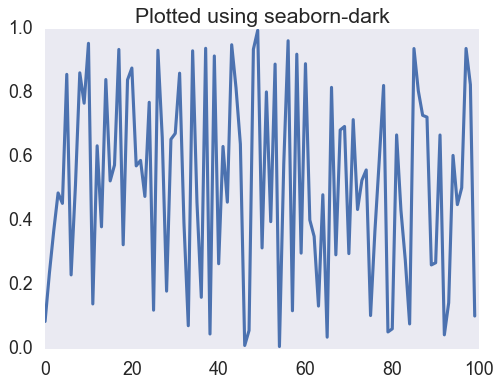

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-darkgrid')

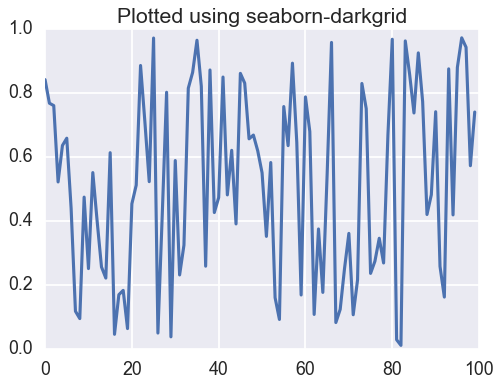

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-ticks')

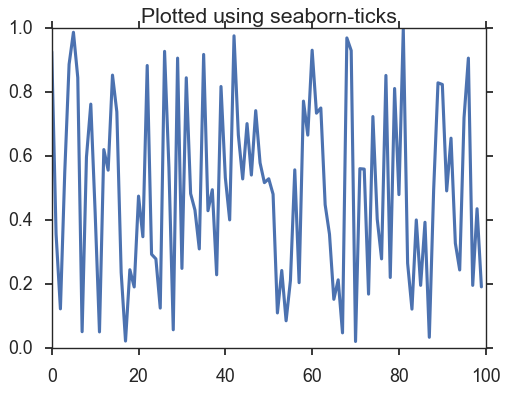

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using fivethirtyeight')

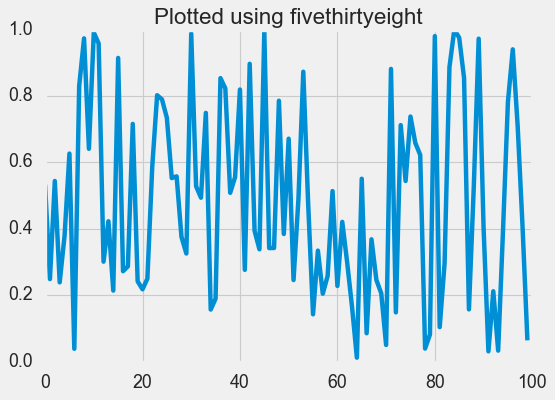

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-whitegrid')

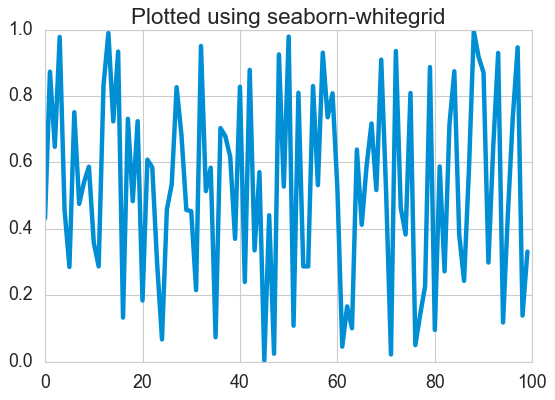

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using classic')

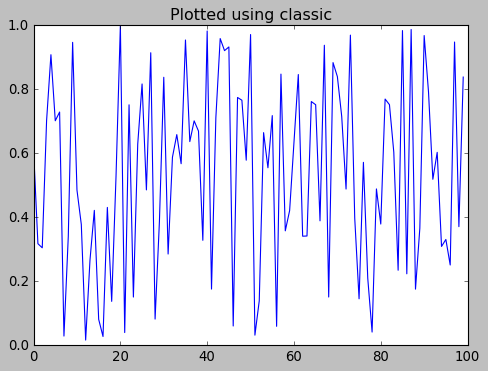

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using _classic_test')

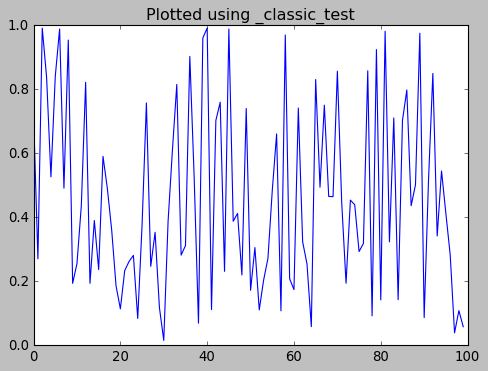

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using fast')

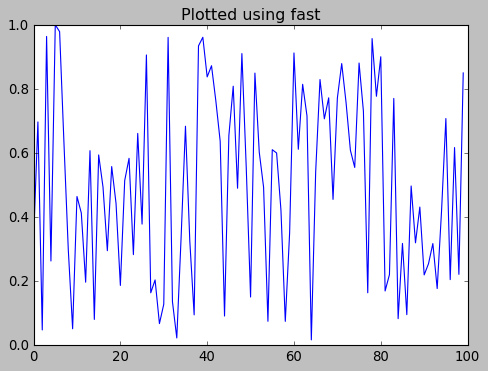

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-talk')

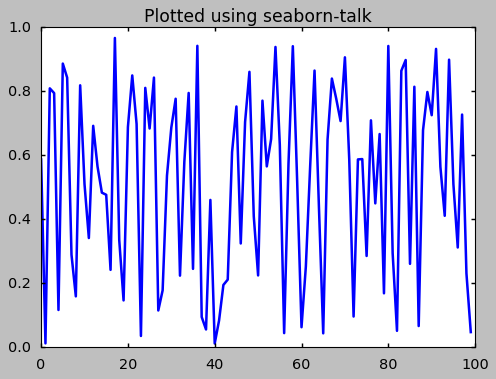

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-dark-palette')

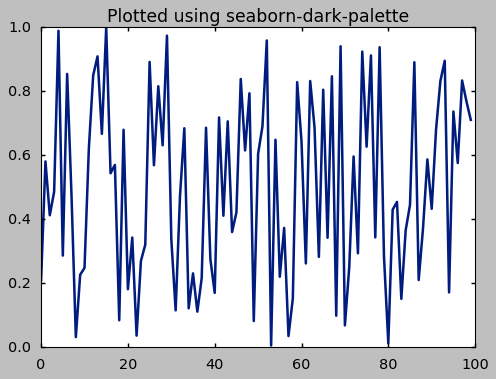

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-bright')

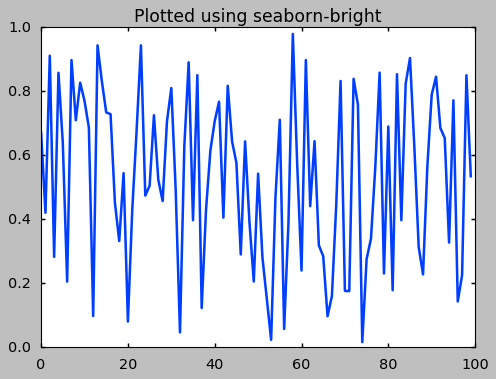

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-pastel')

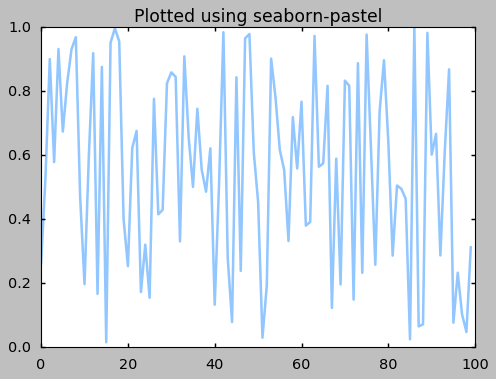

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using grayscale')

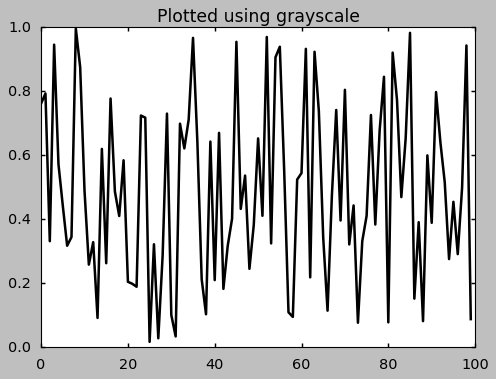

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-notebook')

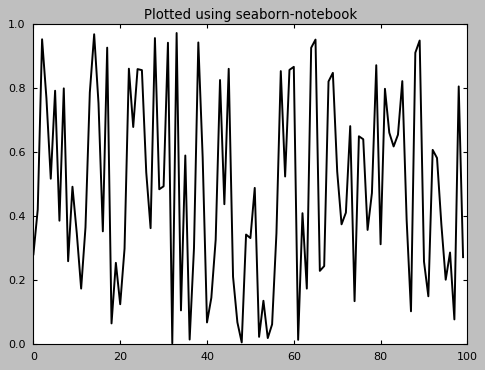

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using ggplot')

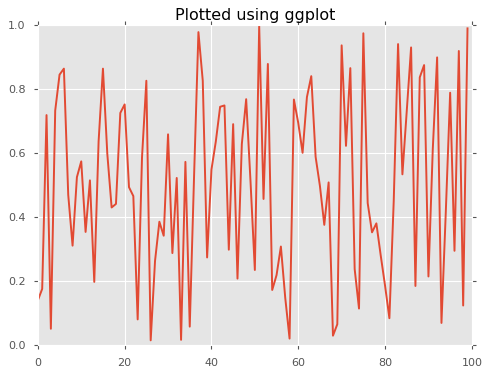

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-colorblind')

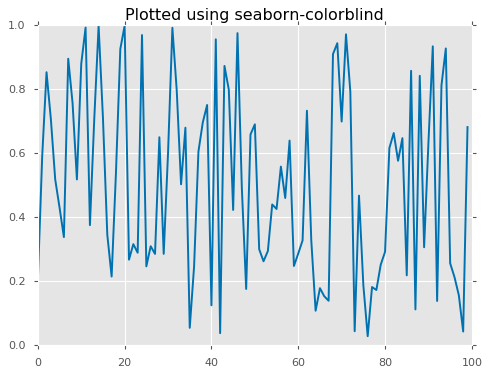

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-muted')

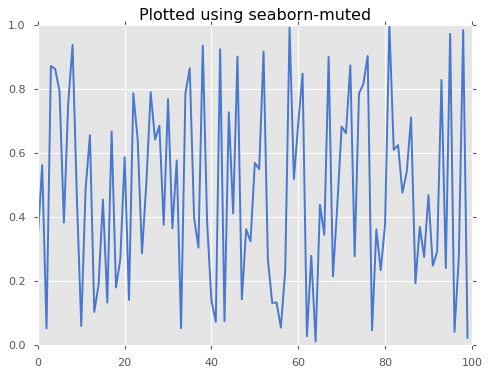

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn')

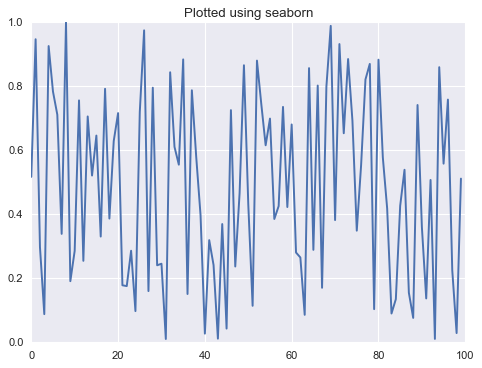

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using Solarize_Light2')

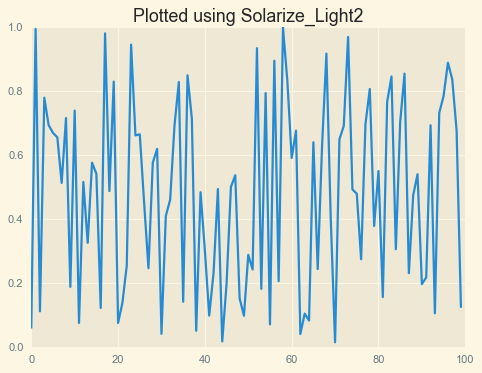

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-paper')

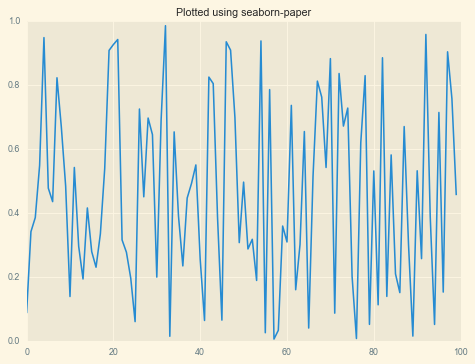

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using bmh')

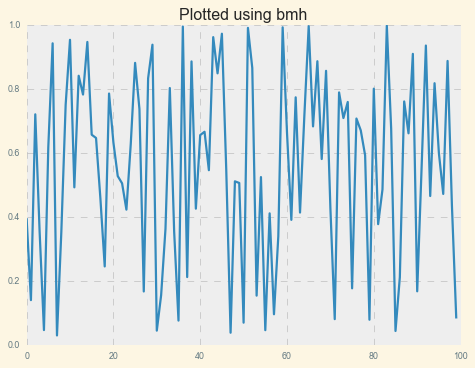

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using tableau-colorblind10')

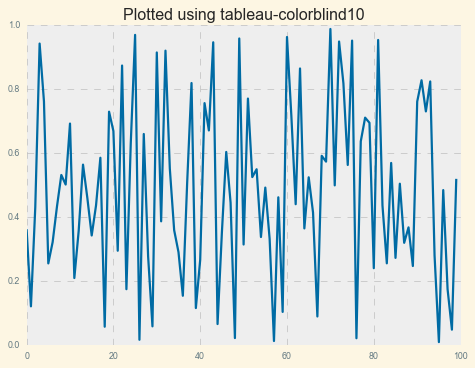

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-white')

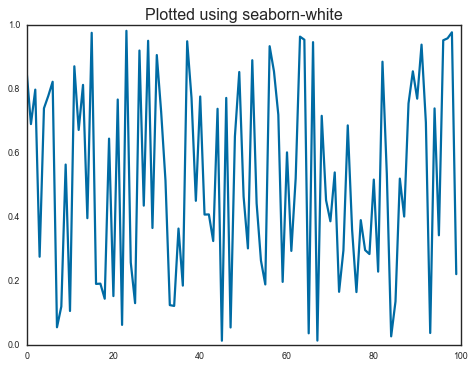

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using dark_background')

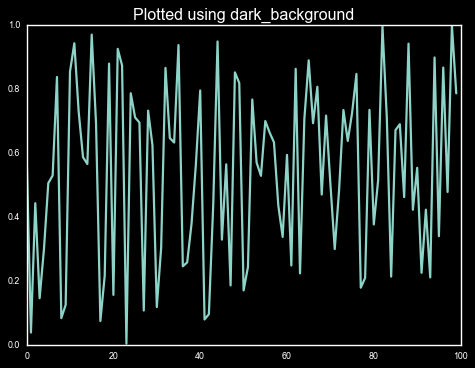

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-poster')

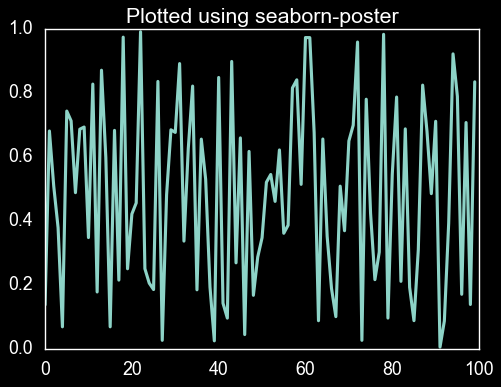

<Figure size 560x400 with 0 Axes>

Text(0.5, 1.0, 'Plotted using seaborn-deep')

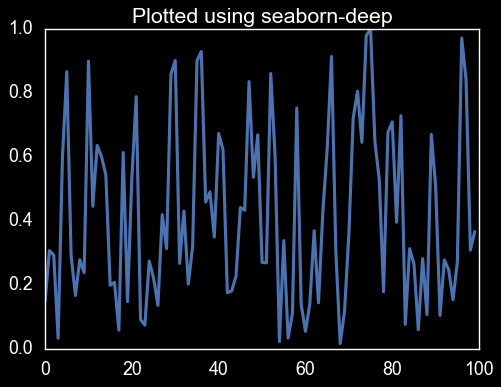

In [568]:
# for style in plt.style.available:
#     plt.style.use(style)
#     plt.figure(figsize=(7,5))
#     plt.plot(np.random.random(100))
#     plt.title('Plotted using {}'.format(style))
#     plt.show()

In [24]:
df = get_data('iris')

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000  

In [98]:
knntree = KNNTree(k=5,measure='euclidean',caliberate_tree_at=10,prune_at=20,points_to_centroid=3)

In [99]:
df.values[:,:4].shape

(150, 4)

In [100]:
shuffeled_arr = df.values[:,:4]
np.random.shuffle(shuffeled_arr)

In [101]:
knn_func = np.vectorize(lambda x : knntree.fit(x))
knntree.fit(shuffeled_arr[:2,:4])

In [102]:
# knn_func(df.values[2:,:4])
knntree

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :2
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0

In [103]:
for i in range(3,150):
    knntree.fit(shuffeled_arr[i,:4].reshape(1,-1))

(1, 0, 1, 1.2620159313363886)
name:1 index: 0 update k_array:
[[4.         0.         0.         0.         0.        ]
 [0.36055513 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]]
(4, 3, 1, 1.2798445359533002)
name:4 index: 3 update k_array:
[[5.         0.         0.         0.         0.        ]
 [0.24494897 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [4.         0.         0.         0.         0.        ]]
(1, 0, 1, 1.2596984518147265)
name:1 index: 0 update k_array:
[[4.         6.         0.         0.         0.        ]
 [0.36055513 0.54772256 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [1.         1.         0.         0.         0.        ]]
(2, 1, 1, 0.6472899578636091)
name:2 index: 1 update k_array:
[[7.         0.         0.         0.         0.     

In [104]:
knntree

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :18
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 3 Index :2 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 4 Index :3 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 5 Index :4 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 6 Index :5 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 7 Index :6 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 8 Index :7 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 9 Index :8 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 10 Index :9 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 11 Index :10 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 12 Index :11 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 13 Index :12 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 14 Index :13 Is Centroid: No Childrens 

In [90]:
df.values[i,:4].reshape(1,-1)

array([[5.9, 3. , 5.1, 1.8]])

In [91]:
knntree.data.shape

(149, 4)

In [92]:
knntree.score(df.values[:50,:4])

[[0.46904158 0.55677644 0.64807407 ... 0.66332496 0.57445626 0.43588989]
 [0.6164414  1.09087121 1.08627805 ... 1.12249722 0.36055513 0.80622577]
 [3.53128872 3.5383612  3.70270172 ... 3.65376518 3.43802269 3.52987252]
 ...
 [0.1        0.54772256 0.51961524 ... 0.59160798 0.31622777 0.24494897]
 [3.09354166 2.96984848 3.15436206 ... 3.09677251 3.0757113  3.03644529]
 [2.58069758 2.55929678 2.7202941  ... 2.67207784 2.51992063 2.56320112]]


(True, 0.0)

In [94]:
knntree.score(np.array([[7.900000,          4.400000,           6.900000,1]]))

[[6.02826675]
 [5.82237065]
 [3.44528664]
 [3.78153408]
 [6.36474666]
 [6.36474666]
 [3.89615195]
 [3.75898923]
 [6.32692658]
 [6.15223537]
 [6.15223537]
 [6.15223537]
 [1.9078784 ]
 [2.00499377]
 [2.00499377]
 [2.00499377]
 [6.26178888]
 [2.51793566]
 [2.0808652 ]
 [2.0808652 ]
 [3.91024296]
 [3.0528675 ]
 [3.0528675 ]
 [2.86705424]
 [2.86705424]
 [6.8541958 ]
 [3.50856096]
 [3.13687743]
 [3.13687743]
 [6.35688603]
 [1.83847763]
 [6.37965516]
 [3.58468967]
 [3.58468967]
 [2.81780056]
 [3.36897611]
 [4.43170396]
 [3.89101529]
 [6.11146464]
 [4.01248053]
 [5.91016074]
 [3.48855271]
 [6.02079729]
 [7.02637887]
 [3.46265794]
 [2.47991935]
 [3.17804972]
 [2.22934968]
 [3.17804972]
 [5.16430053]
 [2.68514432]
 [6.37651943]
 [3.25422802]
 [4.40227214]
 [6.21047502]
 [3.17175031]
 [2.77668868]
 [6.50999232]
 [1.83030052]
 [2.99499583]
 [2.76043475]
 [6.55591336]
 [2.67207784]
 [2.79821372]
 [5.07247474]
 [2.310844  ]
 [2.67207784]
 [3.17647603]
 [4.04227659]
 [3.36897611]
 [6.14003257]
 [2.55

(True, 1.2688577540449524)

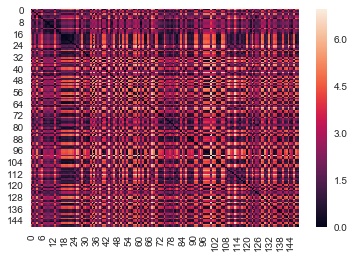

In [105]:
sns.heatmap(pd.DataFrame(knntree.get_centriod_distances()))

In [106]:
knntree.tree

|~~Node Depth :1 Name: None Index :None Is Centroid: No Childrens :18
|  |~~Node Depth :2 Name: 1 Index :0 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 2 Index :1 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 3 Index :2 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 4 Index :3 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 5 Index :4 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 6 Index :5 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 7 Index :6 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 8 Index :7 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 9 Index :8 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 10 Index :9 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 11 Index :10 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 12 Index :11 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 13 Index :12 Is Centroid: No Childrens :0
|  |~~Node Depth :2 Name: 14 Index :13 Is Centroid: No Childrens 